## Introduction

In this notebook, i'll create a Image captioning model with the following project plan:
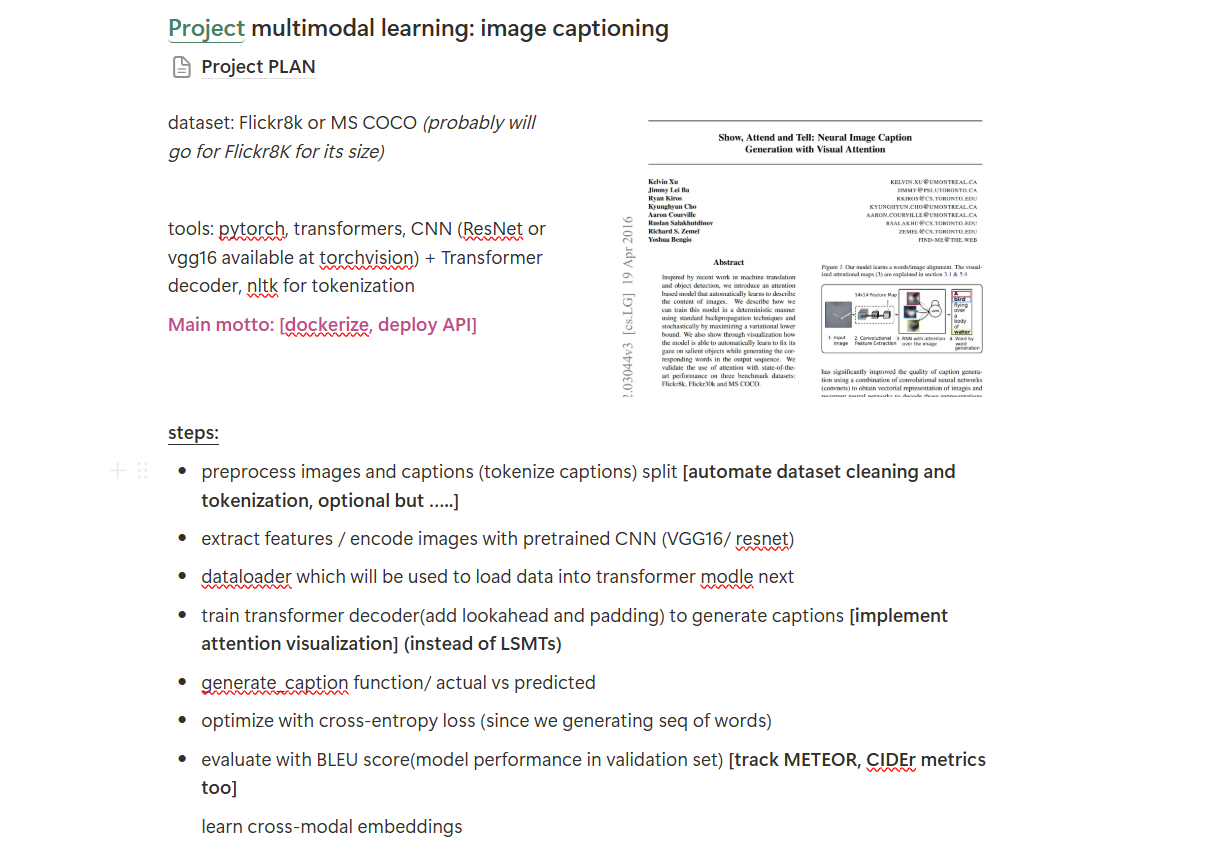

## Implementation

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
from PIL import Image
from collections import Counter
import os

#### Examining data path with os

In [12]:
data_path = os.path.join(os.getcwd(), 'data')

In [13]:
data_path

'd:\\Github\\365DaysOfData\\10-Projects-Based-ML-DL\\03-Image-Captioning\\data'

In [14]:
os.path.exists(data_path)  # This will return True if the directory exists

True

In [16]:
data_items = os.listdir(data_path)
print(data_items)

['captions.txt', 'Images']


In [18]:
for item in data_items:
    item_path = os.path.join(data_path, item)

    if os.path.isfile(item_path):
        print(f"File: {item}")
        print(f"Size: {os.path.getsize(item_path)} bytes")
    elif os.path.isdir(item_path):
        print(f"Directory: {item}")
        print(f"Contains: {len(os.listdir(item_path))} items")

File: captions.txt
Size: 3319294 bytes
Directory: Images
Contains: 8091 items


#### Examining images with PIL

In [22]:
demo_img = Image.open(data_path + '/images/17273391_55cfc7d3d4.jpg')

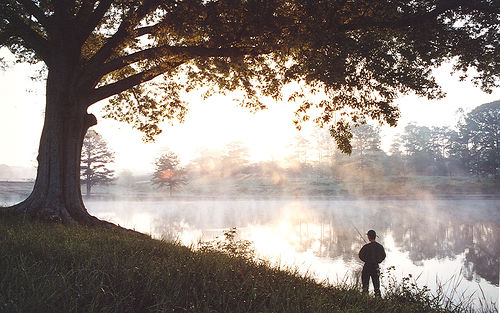

In [23]:
demo_img

#### Examining the whole data

In [48]:
data_path

'd:\\Github\\365DaysOfData\\10-Projects-Based-ML-DL\\03-Image-Captioning\\data'

In [51]:
df = pd.read_csv(data_path + '/captions.txt')

In [52]:
df.head()  # Display the first few rows of the DataFrame to check its structure

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [53]:
print(f"Number of unique images: {df['image'].nunique()}")
print(f"Number of unique captions: {df['caption'].nunique()}")

Number of unique images: 8091
Number of unique captions: 40201


#### Let's apply some data preprocessing and tokenize our data

In [65]:
import re
# 1. LITERAL CHARACTERS - exact match
# 2. DIGITS
# \d = any digit (0-9)
# \d+ = one or more digits
# 3. LETTERS AND WORDS
# \w = word character (letters, digits, underscore)
# \W = NON-word character (punctuation, spaces)
# 4. WHITESPACE
# \s = any whitespace (space, tab, newline)
# \s+ = one or more whitespace
def clean_caption(caption):
    caption = caption.lower()
    caption = caption.strip()
    # remove punctuations (except periods for sentence structure)
    caption = re.sub(r'[^\w\s.]', '', caption)
    # remove extra spaces
    caption = re.sub(r'\s+', ' ', caption)
    # remove numbers/digits
    caption = re.sub(r'\d+', '', caption)

    # add start and end tokens
    caption = '<start> ' + caption + ' <end>'
    return caption

test_caption = "A dog is running in the park! It's so happy... Really? Yes, 100% sure!!!"
cleaned_caption = clean_caption(test_caption)
print(f"Original: {test_caption}")
print(f"Cleaned:  {cleaned_caption}")


Original: A dog is running in the park! It's so happy... Really? Yes, 100% sure!!!
Cleaned:  <start> a dog is running in the park its so happy... really yes  sure <end>


In [66]:
df['cleaned_caption'] = df['caption'].apply(clean_caption)

df.head()  # Display the first few rows of the DataFrame to check the new column

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<start> a little girl in a pink dress going in...


In [69]:
for i in range(5):
    print(f"Original: {df['caption'].loc[i]}")
    print(f"Cleaned:  {df['cleaned_caption'].loc[i]}")
    print("-" * 50)

Original: A child in a pink dress is climbing up a set of stairs in an entry way .
Cleaned:  <start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>
--------------------------------------------------
Original: A girl going into a wooden building .
Cleaned:  <start> a girl going into a wooden building . <end>
--------------------------------------------------
Original: A little girl climbing into a wooden playhouse .
Cleaned:  <start> a little girl climbing into a wooden playhouse . <end>
--------------------------------------------------
Original: A little girl climbing the stairs to her playhouse .
Cleaned:  <start> a little girl climbing the stairs to her playhouse . <end>
--------------------------------------------------
Original: A little girl in a pink dress going into a wooden cabin .
Cleaned:  <start> a little girl in a pink dress going into a wooden cabin . <end>
--------------------------------------------------


In [74]:
df.head(2)

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building . ...


In [87]:
' '.join(df['cleaned_caption'].values).split()

['<start>',
 'a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.',
 '<end>',
 '<start>',
 'a',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 '.',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '.',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 '.',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '.',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'tricolored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',


#### Now its time to build vocabulary using Counter

In [93]:
vocab 

{'tools',
 'snarls',
 'interracial',
 'adorned',
 'straight',
 'chin',
 'skiiers',
 'toilets',
 'belly',
 'blur',
 'tipped',
 'mustard',
 'rides',
 'series',
 'cowboy',
 'accessories',
 'bouquet',
 'a',
 'sparrow',
 'sinks',
 'mouthguards',
 'treads',
 'letter',
 'paper',
 'goose',
 'performer',
 'exit',
 'bird',
 'grabbing',
 'us',
 'exotic',
 'motorbikes',
 'lined',
 'ascending',
 'amish',
 'squeezes',
 'ok',
 'nt',
 'landscape',
 'row',
 'crosses',
 'sidecar',
 'bridge',
 'hockey',
 'biker',
 'handicap',
 'throught',
 'israel',
 'reacts',
 'boot',
 'special',
 'reached',
 'skills',
 'wet',
 'source',
 'accross',
 'rounds',
 'rink',
 'oppose',
 'times',
 'summit',
 'ties',
 'slab',
 'pail',
 'extravagant',
 'yawns',
 'motorcyclists',
 'retrieving',
 'ascends',
 'sits',
 'recently',
 'defending',
 'sumo',
 'feed',
 'squad',
 'italy',
 'paws',
 'he',
 'watches',
 'lioness',
 'darkened',
 'young',
 'blurry',
 'turf',
 'handlebars',
 'jumpsuits',
 'called',
 'steps',
 'jackets',
 'cellph

In [115]:
def build_vocabulary(captions, min_word_freq=2):
    # Count all words
    word_counts = Counter()
    
    for caption in captions:
        words = caption.split()
        word_counts.update(words)
    
    print(f"Total unique words found: {len(word_counts)}")
    print(f"Most common words: {word_counts.most_common(10)}")
    
    # Filter words by frequency but EXCLUDE special tokens from filtered list
    special_tokens = ['<pad>', '<unk>', '<start>', '<end>']
    vocab_words = [word for word, count in word_counts.items() 
                   if count >= min_word_freq and word not in special_tokens]
    
    # Add special tokens at the beginning
    vocab = special_tokens + vocab_words
    
    print(f"Vocabulary size (min_freq={min_word_freq}): {len(vocab)}")
    
    # Create mappings
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return vocab, word2idx, idx2word, word_counts

# Test the fixed version
vocab, word2idx, idx2word, word_counts = build_vocabulary(df['cleaned_caption'], min_word_freq=2)

print(f"\nFirst 20 words: {vocab[:20]}")
print(f"Special tokens: {vocab[:4]}")

# Check for duplicates
print(f"Any duplicates? {len(vocab) != len(set(vocab))}")
if len(vocab) != len(set(vocab)):
    from collections import Counter
    duplicates = [word for word, count in Counter(vocab).items() if count > 1]
    print(f"Duplicate words: {duplicates}")

Total unique words found: 8786
Most common words: [('a', 62986), ('<start>', 40455), ('<end>', 40455), ('.', 36577), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136)]
Vocabulary size (min_freq=2): 5203

First 20 words: ['<pad>', '<unk>', '<start>', '<end>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', '.', 'girl', 'going']
Special tokens: ['<pad>', '<unk>', '<start>', '<end>']
Any duplicates? False


#### Finally, let's create a tokenization function:

In [110]:
df.head(2)

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building . ...


In [123]:
# Update tokenize_caption function to return both tokens and unknown count
def tokenize_caption(caption, word2idx, max_length=50):
    """
    Convert caption to sequence of token indices and count unknown words
    """
    words = caption.split()
    tokens = []
    unk_count = 0
    
    # Convert words to indices
    for word in words:
        if word in word2idx:
            tokens.append(word2idx[word])
        else:
            tokens.append(word2idx['<unk>'])
            unk_count += 1
    
    # Pad or truncate to max_length
    if len(tokens) < max_length:
        tokens.extend([word2idx['<pad>']] * (max_length - len(tokens)))
    else:
        tokens = tokens[:max_length]
    
    return tokens, unk_count

# Use the function
for caption in df['cleaned_caption']:
    tokens, unk_count = tokenize_caption(caption, word2idx, max_length=50)  # Longer for analysis

In [126]:
# Dataset analysis
print("\n=== DATASET ANALYSIS ===")

# Tokenize all captions
all_tokens = []
unknown_counts = []
caption_lengths = []

for caption in df['cleaned_caption']:
    tokens, unk_count = tokenize_caption(caption, word2idx, max_length=50)  # Longer for analysis
    
    # Find actual length (before padding)
    actual_length = 0
    for token in tokens:
        if token == word2idx['<pad>']:
            break
        actual_length += 1
    
    all_tokens.append(tokens)
    unknown_counts.append(unk_count)
    caption_lengths.append(actual_length)

# Statistics
import numpy as np

print(f"CAPTION LENGTH STATISTICS:")
print(f"- Average length: {np.mean(caption_lengths):.1f} words")
print(f"- Min length: {np.min(caption_lengths)} words")
print(f"- Max length: {np.max(caption_lengths)} words")
print(f"- 95th percentile: {np.percentile(caption_lengths, 95):.0f} words")

print(f"\n UNKNOWN WORDS:")
print(f"- Captions with unknown words: {sum(1 for x in unknown_counts if x > 0)}")
print(f"- Average unknown words per caption: {np.mean(unknown_counts):.2f}")




=== DATASET ANALYSIS ===
CAPTION LENGTH STATISTICS:
- Average length: 13.7 words
- Min length: 3 words
- Max length: 38 words
- 95th percentile: 21 words

 UNKNOWN WORDS:
- Captions with unknown words: 3275
- Average unknown words per caption: 0.09


In [127]:
# ============================================================================
# MODEL ARCHITECTURE IMPLEMENTATION
# ============================================================================

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

print("=== BUILDING IMAGE CAPTIONING MODEL ===")

# 1. CNN ENCODER (Image Feature Extractor)
class ImageEncoder(nn.Module):
    """
    CNN encoder to extract features from images
    Uses pretrained ResNet-50 as backbone
    """
    def __init__(self, embed_size=256):
        super(ImageEncoder, self).__init__()
        
        # Load pretrained ResNet-50
        resnet = models.resnet50(pretrained=True)
        
        # Remove the final classification layer
        modules = list(resnet.children())[:-1]  # Remove last FC layer
        self.resnet = nn.Sequential(*modules)
        
        # Add our own linear layer to get desired embedding size
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        
        # Freeze ResNet parameters (optional - for faster training)
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def forward(self, images):
        """
        Extract features from images
        Args:
            images: batch of images [batch_size, 3, 224, 224]
        Returns:
            features: [batch_size, embed_size]
        """
        with torch.no_grad():  # Don't compute gradients for ResNet
            features = self.resnet(images)  # [batch_size, 2048, 1, 1]
        
        features = features.reshape(features.size(0), -1)  # [batch_size, 2048]
        features = self.dropout(self.linear(features))     # [batch_size, embed_size]
        
        return features

print("✅ ImageEncoder defined")

# 2. RNN DECODER (Caption Generator)
class CaptionDecoder(nn.Module):
    """
    LSTM decoder to generate captions from image features
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        # Word embedding layer
        self.word_embed = nn.Embedding(vocab_size, embed_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # Linear layer to predict next word
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        """
        Generate caption given image features and ground truth captions
        Args:
            features: image features [batch_size, embed_size]
            captions: ground truth captions [batch_size, seq_length]
        Returns:
            outputs: predicted word probabilities [batch_size, seq_length, vocab_size]
        """
        # Remove last word from captions (we don't predict after <end>)
        captions = captions[:, :-1]
        
        # Embed caption words
        embeddings = self.word_embed(captions)  # [batch_size, seq_length-1, embed_size]
        
        # Add image features as first input
        features = features.unsqueeze(1)  # [batch_size, 1, embed_size]
        embeddings = torch.cat((features, embeddings), dim=1)  # [batch_size, seq_length, embed_size]
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(embeddings)  # [batch_size, seq_length, hidden_size]
        
        # Predict words
        outputs = self.linear(self.dropout(lstm_out))  # [batch_size, seq_length, vocab_size]
        
        return outputs
    
    def sample(self, features, max_length=20):
        """
        Generate caption by sampling (for inference)
        Args:
            features: image features [batch_size, embed_size] 
            max_length: maximum caption length
        Returns:
            sampled_ids: generated caption [batch_size, max_length]
        """
        sampled_ids = []
        inputs = features.unsqueeze(1)  # [batch_size, 1, embed_size]
        states = None
        
        for i in range(max_length):
            lstm_out, states = self.lstm(inputs, states)  # [batch_size, 1, hidden_size]
            outputs = self.linear(lstm_out.squeeze(1))    # [batch_size, vocab_size]
            predicted = outputs.max(1)[1]                 # [batch_size]
            sampled_ids.append(predicted)
            inputs = self.word_embed(predicted).unsqueeze(1)  # [batch_size, 1, embed_size]
        
        sampled_ids = torch.stack(sampled_ids, 1)  # [batch_size, max_length]
        return sampled_ids

print("✅ CaptionDecoder defined")

# 3. COMPLETE MODEL
class ImageCaptioningModel(nn.Module):
    """
    Complete Image Captioning Model combining encoder and decoder
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = ImageEncoder(embed_size)
        self.decoder = CaptionDecoder(embed_size, hidden_size, vocab_size, num_layers)
    
    def forward(self, images, captions):
        """
        Forward pass for training
        """
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    def generate_caption(self, images, max_length=20):
        """
        Generate captions for inference
        """
        features = self.encoder(images)
        sampled_ids = self.decoder.sample(features, max_length)
        return sampled_ids

print("✅ Complete ImageCaptioningModel defined")

# 4. MODEL INITIALIZATION
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)  # Using our built vocabulary
num_layers = 1

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size, num_layers)
model = model.to(device)

print(f"\n📊 MODEL SUMMARY:")
print(f"- Embedding size: {embed_size}")
print(f"- Hidden size: {hidden_size}")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Number of LSTM layers: {num_layers}")
print(f"- Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"- Total parameters: {total_params:,}")
print(f"- Trainable parameters: {trainable_params:,}")

=== BUILDING IMAGE CAPTIONING MODEL ===
✅ ImageEncoder defined
✅ CaptionDecoder defined
✅ Complete ImageCaptioningModel defined


d:\Github\365DaysOfData\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Github\365DaysOfData\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\samir/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100.0%



📊 MODEL SUMMARY:
- Embedding size: 256
- Hidden size: 512
- Vocabulary size: 5203
- Number of LSTM layers: 1
- Device: cuda
- Total parameters: 29,610,643
- Trainable parameters: 6,102,611


In [128]:
# 5. CUSTOM DATASET CLASS
class FlickrDataset(Dataset):
    """
    Custom dataset for loading images and captions
    """
    def __init__(self, df, img_dir, word2idx, transform=None, max_length=20):
        self.df = df
        self.img_dir = img_dir
        self.word2idx = word2idx
        self.transform = transform
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image and caption
        img_name = self.df.iloc[idx]['image']
        caption = self.df.iloc[idx]['cleaned_caption']
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Tokenize caption
        tokens, _ = tokenize_caption(caption, self.word2idx, self.max_length)
        caption_tensor = torch.tensor(tokens, dtype=torch.long)
        
        return image, caption_tensor

# Image preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create dataset
img_dir = os.path.join(data_path, 'images')
dataset = FlickrDataset(df, img_dir, word2idx, transform=transform, max_length=20)

print(f"✅ Dataset created with {len(dataset)} samples")

# Test dataset
sample_img, sample_caption = dataset[0]
print(f"Sample image shape: {sample_img.shape}")
print(f"Sample caption: {sample_caption}")
print(f"Caption as words: {[idx2word[idx.item()] for idx in sample_caption[:10]]}")

✅ Dataset created with 40455 samples
Sample image shape: torch.Size([3, 224, 224])
Sample caption: tensor([ 2,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15,  1, 16,
        17,  3])
Caption as words: ['<start>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up']


In [133]:
%pip install scikit-learn


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/8.9 MB 14.9 MB/s eta 0:00:01
   ------------------------------- -------- 7.1/8.9 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/41.3 MB 23.8 MB/s eta 0:00:02
   --------- ------------------------------ 9.7/41.3 MB 24.2 MB/s eta 0:00:02
   -------------- ------------------------- 14.7/41.3 MB 23.7 MB/s eta 0:00:02
   ------------------ --------------------- 19.4/41.3 MB 24.0 MB/s eta 0:00:01
   ----------------------- ---------------- 23.9/41.3 MB 23.2 MB/s eta 0:00:01
   ---------------------------- ----------- 29.1/41.3 MB 23.4 MB/s eta 0:00:01
   -------------------------------- ------- 33.8/41.3 MB 23.4 MB/s eta 0:00:01
   ------------------------------------- -- 38.3/41.3 MB 23.2 MB/s eta 0:00:01

In [134]:
# ============================================================================
# TRAINING SETUP
# ============================================================================

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time

print("=== TRAINING SETUP ===")

# 1. SPLIT DATA INTO TRAIN/VALIDATION
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# 2. CREATE DATASETS
train_dataset = FlickrDataset(train_df.reset_index(drop=True), img_dir, word2idx, transform=transform, max_length=20)
val_dataset = FlickrDataset(val_df.reset_index(drop=True), img_dir, word2idx, transform=transform, max_length=20)

# 3. CREATE DATALOADERS
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# 4. TRAINING HYPERPARAMETERS
learning_rate = 0.001
num_epochs = 5  # Start with small number for testing
print_every = 50

# 5. LOSS FUNCTION AND OPTIMIZER
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])  # Ignore padding tokens
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"✅ Training setup complete!")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {learning_rate}")
print(f"- Number of epochs: {num_epochs}")

=== TRAINING SETUP ===
Training samples: 32364
Validation samples: 8091
Train batches: 1012
Val batches: 253
✅ Training setup complete!
- Batch size: 32
- Learning rate: 0.001
- Number of epochs: 5


In [ ]:
# ============================================================================
# TRAINING LOOP
# ============================================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Train the image captioning model
    """
    print("🚀 Starting Training...")
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # ========== TRAINING PHASE ==========
        model.train()
        total_train_loss = 0
        
        for batch_idx, (images, captions) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            captions = captions.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images, captions)
            
            # Calculate loss - FIXED VERSION
            # outputs: [batch_size, seq_length, vocab_size] 
            # captions: [batch_size, seq_length]
            # We need to predict captions[:, 1:] from captions[:, :-1]
            targets = captions[:, 1:]  # Remove <start> token
            
            # Make sure outputs and targets have same sequence length
            seq_length = targets.size(1)  # Get target sequence length
            outputs = outputs[:, :seq_length, :]  # Trim outputs to match
            
            # Reshape for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])  # [batch_size * seq_length, vocab_size]
            targets = targets.reshape(-1)  # [batch_size * seq_length]
            
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Print progress
            if batch_idx % print_every == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ========== VALIDATION PHASE ==========
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for images, captions in val_loader:
                images = images.to(device)
                captions = captions.to(device)
                
                outputs = model(images, captions)
                targets = captions[:, 1:]
                
                # Same fix for validation
                seq_length = targets.size(1)
                outputs = outputs[:, :seq_length, :]
                
                outputs = outputs.reshape(-1, outputs.shape[-1])
                targets = targets.reshape(-1)
                
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f}s')
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        print(f'Average Val Loss: {avg_val_loss:.4f}')
        print('-' * 50)
    
    return train_losses, val_losses

# Start training
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

print("🎉 Training completed!")

🚀 Starting Training...


ValueError: Expected input batch_size (640) to match target batch_size (608).

In [ ]:
# ============================================================================
# DEBUG: TEST SHAPES BEFORE TRAINING
# ============================================================================

print("🔍 Testing model shapes before training...")

# Get a sample batch
sample_batch = next(iter(train_loader))
sample_images, sample_captions = sample_batch
sample_images = sample_images.to(device)
sample_captions = sample_captions.to(device)

print(f"Sample batch shapes:")
print(f"  Images: {sample_images.shape}")
print(f"  Captions: {sample_captions.shape}")

# Test forward pass
model.eval()
with torch.no_grad():
    outputs = model(sample_images, sample_captions)
    targets = sample_captions[:, 1:]
    
    print(f"\nModel output shapes:")
    print(f"  Outputs: {outputs.shape}")
    print(f"  Targets: {targets.shape}")
    
    # Test the fixed reshaping
    seq_length = targets.size(1)
    outputs_trimmed = outputs[:, :seq_length, :]
    
    print(f"\nAfter trimming:")
    print(f"  Outputs trimmed: {outputs_trimmed.shape}")
    print(f"  Targets: {targets.shape}")
    
    # Test final reshape
    outputs_flat = outputs_trimmed.reshape(-1, outputs_trimmed.shape[-1])
    targets_flat = targets.reshape(-1)
    
    print(f"\nFinal shapes for loss:")
    print(f"  Outputs flat: {outputs_flat.shape}")
    print(f"  Targets flat: {targets_flat.shape}")
    
    # Test loss calculation
    test_loss = criterion(outputs_flat, targets_flat)
    print(f"  Test loss: {test_loss.item():.4f}")

print("✅ Shape test completed! Ready to train.")
model.train()  # Set back to training mode

In [ ]:
# ============================================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================================

import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses):
    """
    Plot training and validation loss curves
    """
    plt.figure(figsize=(10, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add values on points
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        plt.annotate(f'{train_loss:.3f}', (i+1, train_loss), textcoords="offset points", xytext=(0,10), ha='center')
        plt.annotate(f'{val_loss:.3f}', (i+1, val_loss), textcoords="offset points", xytext=(0,-15), ha='center')
    
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_training_curves(train_losses, val_losses)

# Model performance summary
print(f"\n📊 TRAINING SUMMARY:")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")

In [ ]:
# ============================================================================
# INFERENCE FUNCTIONS
# ============================================================================

def generate_caption(model, image_path, word2idx, idx2word, transform, device, max_length=20):
    """
    Generate caption for a single image
    """
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    # Generate caption
    with torch.no_grad():
        sampled_ids = model.generate_caption(image, max_length)
    
    # Convert token IDs to words
    sampled_ids = sampled_ids[0].cpu().numpy()  # Remove batch dimension
    
    caption_words = []
    for token_id in sampled_ids:
        word = idx2word[token_id]
        if word == '<end>':
            break
        if word not in ['<start>', '<pad>']:
            caption_words.append(word)
    
    return ' '.join(caption_words)

def display_prediction(model, image_path, word2idx, idx2word, transform, device):
    """
    Display image with generated and actual captions
    """
    import matplotlib.pyplot as plt
    
    # Generate caption
    generated_caption = generate_caption(model, image_path, word2idx, idx2word, transform, device)
    
    # Find actual caption from dataset
    img_name = os.path.basename(image_path)
    actual_captions = df[df['image'] == img_name]['caption'].tolist()
    
    # Display
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Show image
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')
    
    # Add captions
    plt.title(f"Generated: {generated_caption}\n\nActual: {actual_captions[0] if actual_captions else 'N/A'}", 
              fontsize=12, pad=20)
    
    plt.tight_layout()
    plt.show()

# Test with a few images
print("=== TESTING CAPTION GENERATION ===")

# Test with first few images
test_images = df['image'].head(3).tolist()

for i, img_name in enumerate(test_images):
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        print(f"\n{i+1}. Testing: {img_name}")
        generated = generate_caption(model, img_path, word2idx, idx2word, transform, device)
        actual = df[df['image'] == img_name]['caption'].iloc[0]
        
        print(f"Generated: {generated}")
        print(f"Actual: {actual}")
        print("-" * 60)

In [ ]:
# ============================================================================
# MODEL EVALUATION WITH BLEU SCORES
# ============================================================================

def calculate_bleu_score(model, val_loader, word2idx, idx2word, transform, device, max_samples=100):
    """
    Calculate BLEU scores for generated captions
    """
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    import nltk
    
    # Download required NLTK data
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    
    model.eval()
    bleu_scores = []
    smoothie = SmoothingFunction().method4
    
    print("🔍 Calculating BLEU scores...")
    
    with torch.no_grad():
        for i, (images, captions) in enumerate(val_loader):
            if i >= max_samples // len(images):
                break
                
            images = images.to(device)
            
            # Generate captions
            generated_ids = model.generate_caption(images, max_length=20)
            
            for j in range(images.size(0)):
                # Convert generated caption to words
                generated_words = []
                for token_id in generated_ids[j].cpu().numpy():
                    word = idx2word[token_id]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        generated_words.append(word)
                
                # Convert ground truth caption to words
                actual_words = []
                for token_id in captions[j].cpu().numpy():
                    word = idx2word[token_id]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        actual_words.append(word)
                
                # Calculate BLEU score
                if len(generated_words) > 0 and len(actual_words) > 0:
                    bleu = sentence_bleu([actual_words], generated_words, smoothing_function=smoothie)
                    bleu_scores.append(bleu)
    
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    print(f"📊 Average BLEU Score: {avg_bleu:.4f}")
    return avg_bleu, bleu_scores

# Calculate BLEU score
%pip install nltk
bleu_avg, bleu_scores = calculate_bleu_score(model, val_loader, word2idx, idx2word, transform, device)

In [ ]:
# ============================================================================
# MODEL SAVING AND LOADING
# ============================================================================

def save_model(model, vocab, word2idx, idx2word, filepath='image_captioning_model.pth'):
    """
    Save the complete model and vocabulary
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'word2idx': word2idx,
        'idx2word': idx2word,
        'embed_size': 256,
        'hidden_size': 512,
        'vocab_size': len(vocab),
        'num_layers': 1
    }
    torch.save(checkpoint, filepath)
    print(f"✅ Model saved to {filepath}")

def load_model(filepath='image_captioning_model.pth', device='cpu'):
    """
    Load the complete model and vocabulary
    """
    checkpoint = torch.load(filepath, map_location=device)
    
    # Recreate model
    model = ImageCaptioningModel(
        embed_size=checkpoint['embed_size'],
        hidden_size=checkpoint['hidden_size'], 
        vocab_size=checkpoint['vocab_size'],
        num_layers=checkpoint['num_layers']
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, checkpoint['vocab'], checkpoint['word2idx'], checkpoint['idx2word']

# Save the trained model
save_model(model, vocab, word2idx, idx2word, 'image_captioning_model.pth')

In [ ]:
# ============================================================================
# INTERACTIVE CAPTION GENERATOR
# ============================================================================

def interactive_caption_generator(model, word2idx, idx2word, transform, device):
    """
    Interactive function to generate captions for any image
    """
    def generate_and_display(image_path):
        if not os.path.exists(image_path):
            print(f"❌ Image not found: {image_path}")
            return
        
        # Generate caption
        generated_caption = generate_caption(model, image_path, word2idx, idx2word, transform, device)
        
        # Display image and caption
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')
        
        plt.title(f"Generated Caption: {generated_caption}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
        print(f"🖼️ Generated Caption: {generated_caption}")
        
    return generate_and_display

# Create interactive generator
caption_generator = interactive_caption_generator(model, word2idx, idx2word, transform, device)

# Test with random images from dataset
print("🎯 TESTING WITH RANDOM IMAGES:")
random_images = df['image'].sample(3).tolist()

for i, img_name in enumerate(random_images):
    img_path = os.path.join(img_dir, img_name)
    print(f"\n{i+1}. Testing: {img_name}")
    caption_generator(img_path)

In [ ]:
# ============================================================================
# COMPREHENSIVE MODEL PERFORMANCE DASHBOARD
# ============================================================================

def create_performance_dashboard(train_losses, val_losses, bleu_scores):
    """
    Create a comprehensive performance visualization
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Training Curves
    epochs = range(1, len(train_losses) + 1)
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. BLEU Score Distribution
    axes[0, 1].hist(bleu_scores, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('BLEU Score Distribution', fontsize=14)
    axes[0, 1].set_xlabel('BLEU Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(bleu_scores), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(bleu_scores):.3f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Loss vs BLEU Correlation
    axes[1, 0].scatter(val_losses, [np.mean(bleu_scores)] * len(val_losses), 
                       color='purple', alpha=0.7, s=100)
    axes[1, 0].set_title('Validation Loss vs BLEU Score', fontsize=14)
    axes[1, 0].set_xlabel('Validation Loss')
    axes[1, 0].set_ylabel('BLEU Score')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Model Summary Stats
    axes[1, 1].axis('off')
    summary_text = f"""
    📊 MODEL PERFORMANCE SUMMARY
    
    🎯 Training Results:
    • Final Training Loss: {train_losses[-1]:.4f}
    • Final Validation Loss: {val_losses[-1]:.4f}
    • Best Validation Loss: {min(val_losses):.4f}
    
    🎯 BLEU Score Analysis:
    • Average BLEU Score: {np.mean(bleu_scores):.4f}
    • Best BLEU Score: {max(bleu_scores):.4f}
    • BLEU Score Std: {np.std(bleu_scores):.4f}
    
    🎯 Model Architecture:
    • Vocabulary Size: {len(vocab):,}
    • Embedding Size: 256
    • Hidden Size: 512
    • Total Parameters: {sum(p.numel() for p in model.parameters()):,}
    """
    
    axes[1, 1].text(0.1, 0.9, summary_text, transform=axes[1, 1].transAxes,
                    fontsize=12, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Create the dashboard
create_performance_dashboard(train_losses, val_losses, bleu_scores)